In [9]:
import os
import sys

current_working_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(current_working_directory))
utils_path = os.path.join(project_directory, 'utils')
plotting_path = os.path.join(project_directory, 'plotting_templates')
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [10]:
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utilities
from utils_DST import *
from utils_elliptic_dst_2d import create_interior
from utils_error import compute_2d_error
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [11]:
plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

In [12]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

# Draw random samples for the Random feature embedding part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2
sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff
def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)


Number of samples:  32


In [13]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + bu+c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}



In [14]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [15]:
key = random.PRNGKey(647023)

c = 1.0
beta = 0.5

n_coef = 2**10
print("Number of coefficients: ", n_coef)

nu = 1e-1
b = jit(lambda x, y:1)#jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:] # make sure to exclude the points 0 and 1!
y_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x_finest, y_finest)
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef) + 1
delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))


decay = (jnp.arange(1,n_coef + 1)[None]**2 + jnp.arange(1,n_coef+1)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))

tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)

u_values = dst_2d(coef_u)
f_values = dst_2d(coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values)
coef_f = compute_sine_coef_2d(f_values)

Number of coefficients:  1024


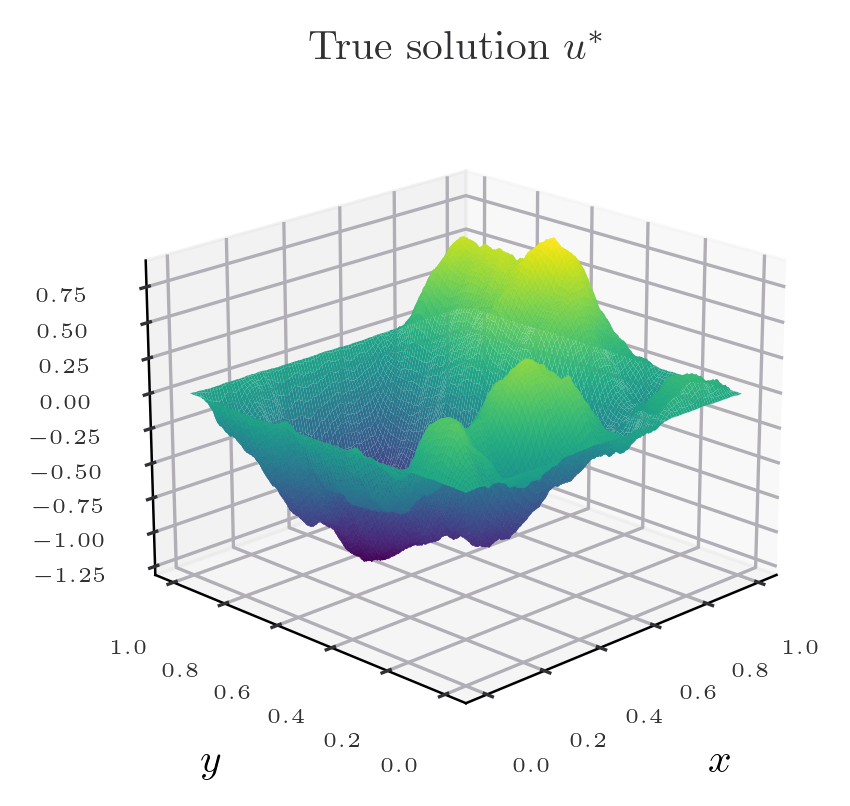

: 

In [16]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 10
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

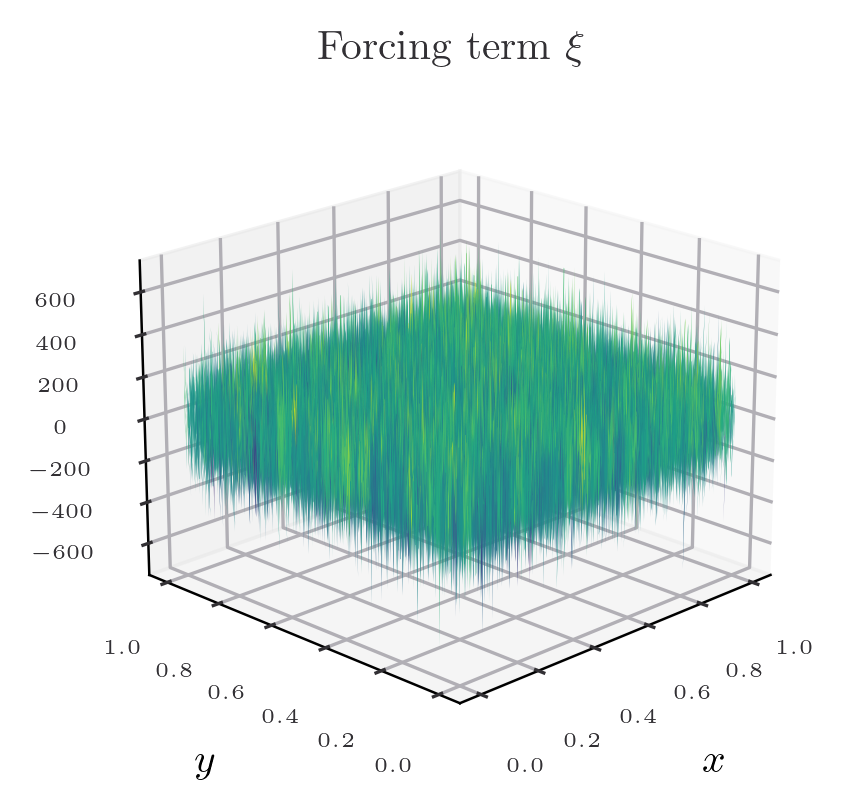

In [10]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

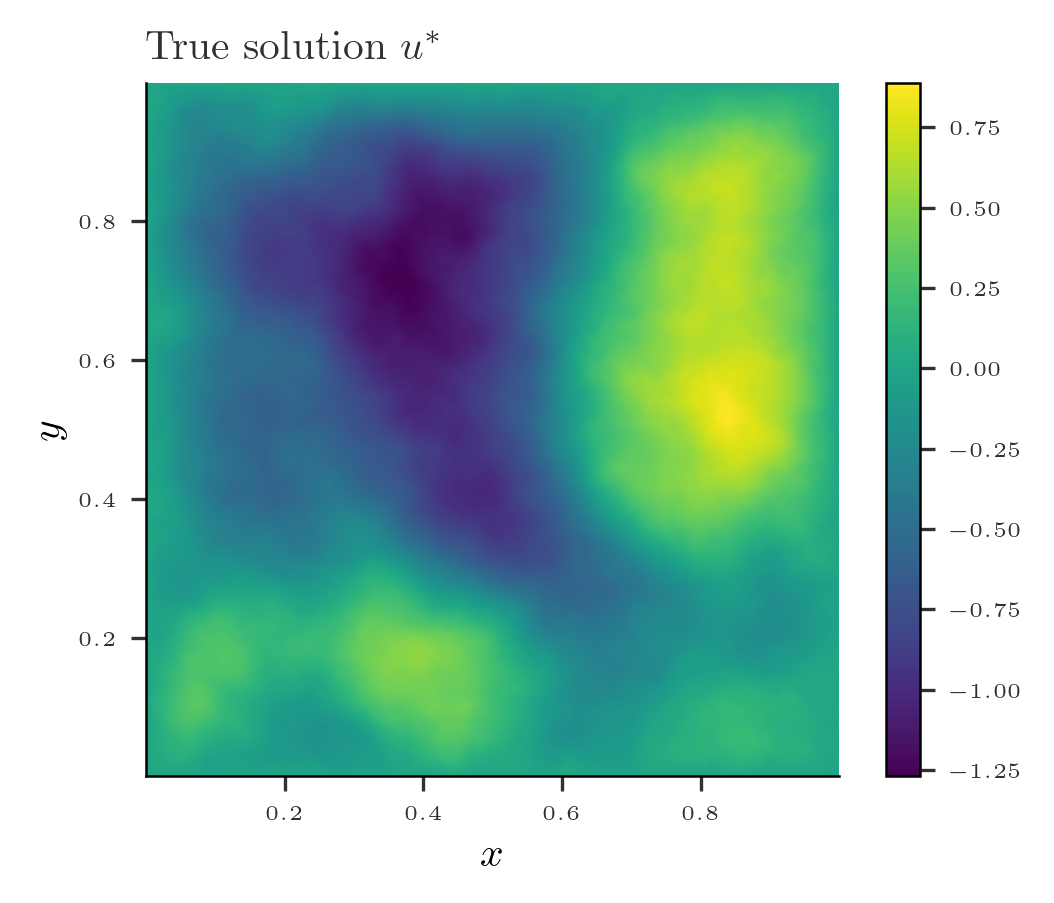

In [11]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

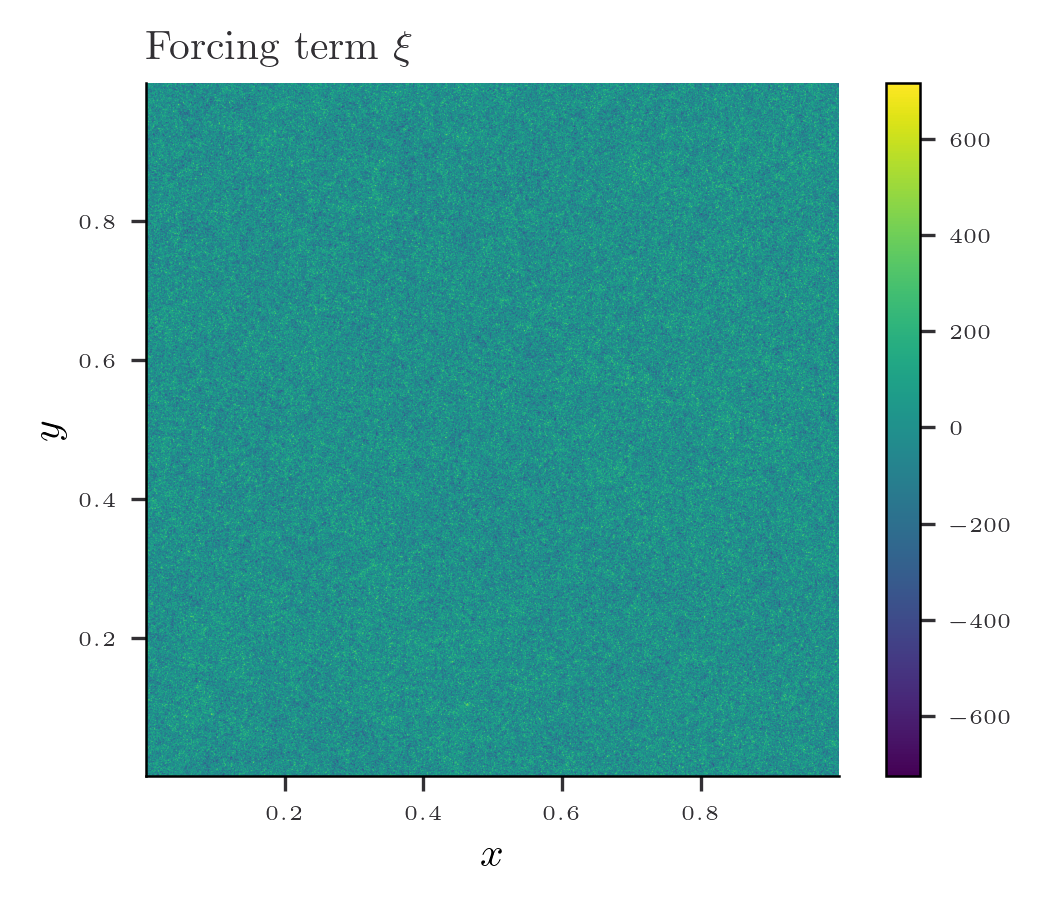

In [12]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

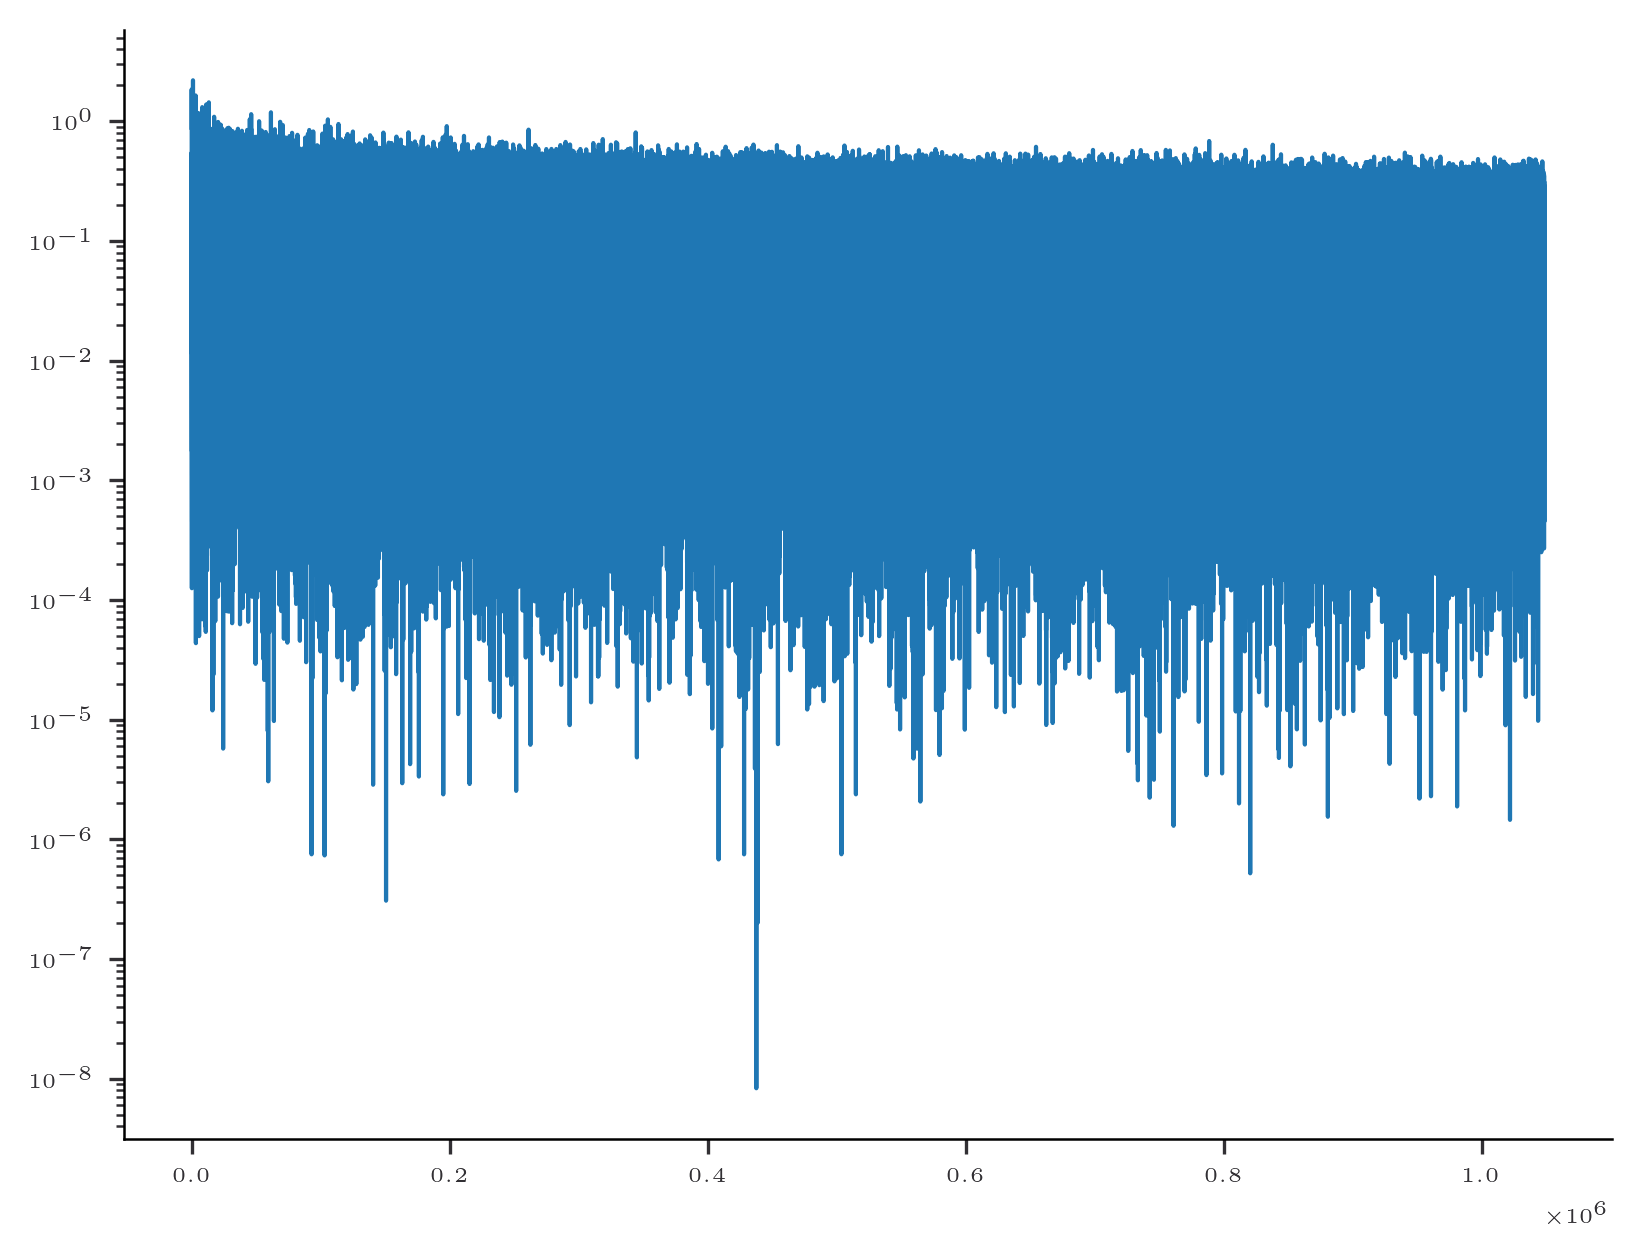

In [13]:
plt.plot(jnp.abs(coef_f.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

In [14]:
# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:] # remember to not include the points 0 and 1
y = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)

# Create the boundary
# Boundary points
boundary = jnp.hstack([jnp.zeros(1), x, jnp.zeros(1)])
n_boundary = boundary.shape[0]
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

n_eval = 2**8
x_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
y_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] #jnp.hstack([jnp.zeros(1),jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:], jnp.zeros(1)])
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

ratio = int(n_coef/n_eval)
u_eval = u_values[::ratio, ::ratio]

Number of points 64 (4096 measurements)
Number of boundary points: 66 (264 total)


## Computing a solution using a negative Sobolev norm $H^{-1}$ loss 

In [15]:
s = 1.0 # Negative sobolev norm for the loss
decay_nugget =  decay = (jnp.arange(1,n_points + 1)[None]**2 + jnp.arange(1,n_points+1)[:,None]**2)**(-s/2)
f_observed =  coef_f[:n_points,:n_points]

In [17]:
layer_sizes = [n_samples*2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = compute_sine_coef_2d(-nu*laplacian_grid + vmap_b(x,y)*u_grid+ non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

There are 8385 parameters in the neural network.


In [20]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [21]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.8469853
Step 0, Training Loss: 0.8469853, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0000537
Step 10000, Training Loss: 0.0000537, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0000433
Step 20000, Training Loss: 0.0000433, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000372
Step 30000, Training Loss: 0.0000372, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000315
Step 40000, Training Loss: 0.0000315, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000287
Step 50000, Training Loss: 0.0000287, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000248
Step 60000, Training Loss: 0.0000248, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000222
Step 70000, Training Loss: 0.0000222, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000202
Step 80000, Training Loss: 0.0000202, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000193
Step 90000, Training Loss: 0.0000193, Learning Rate: 0.000387


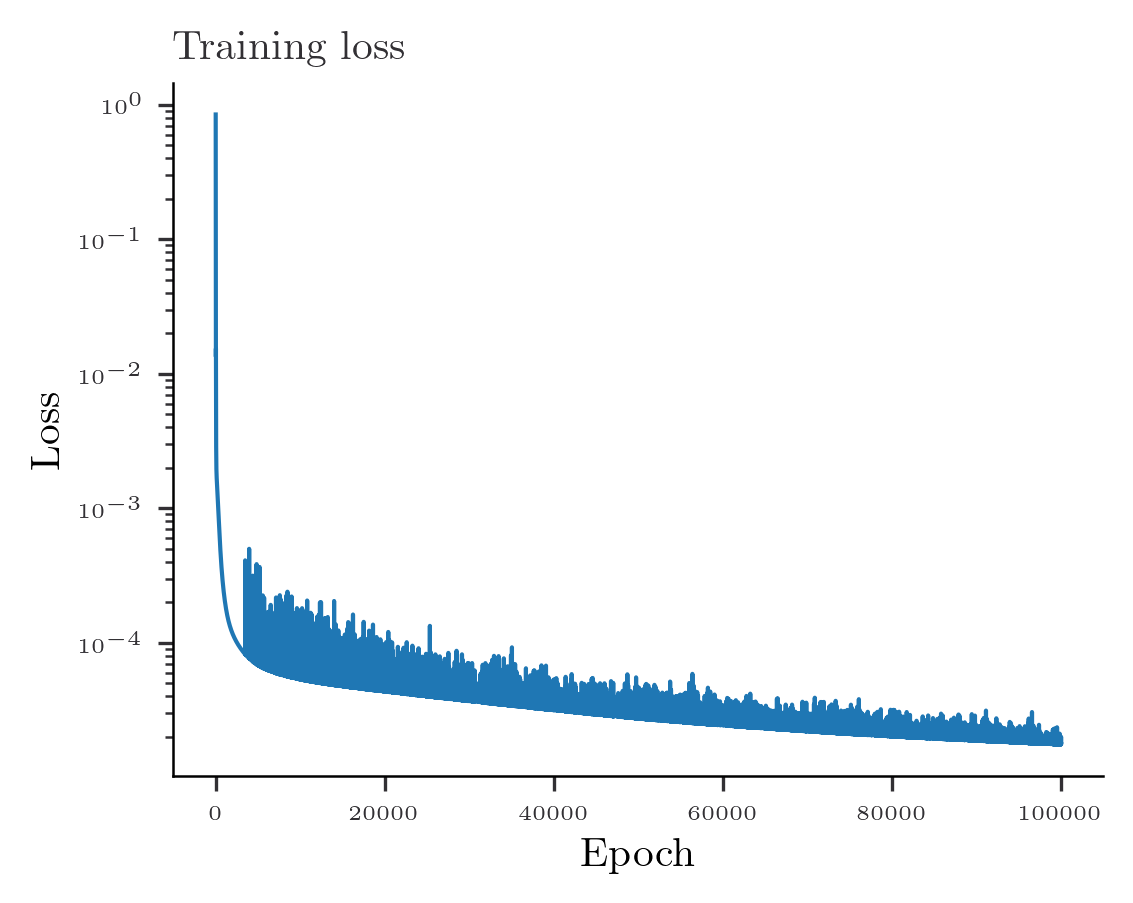

In [22]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [23]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)
e, e_rel = compute_2d_error(pred_grid, u_eval, x_eval, y_eval)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 1.04e-02. The relative L^2 error is 2.03e-02


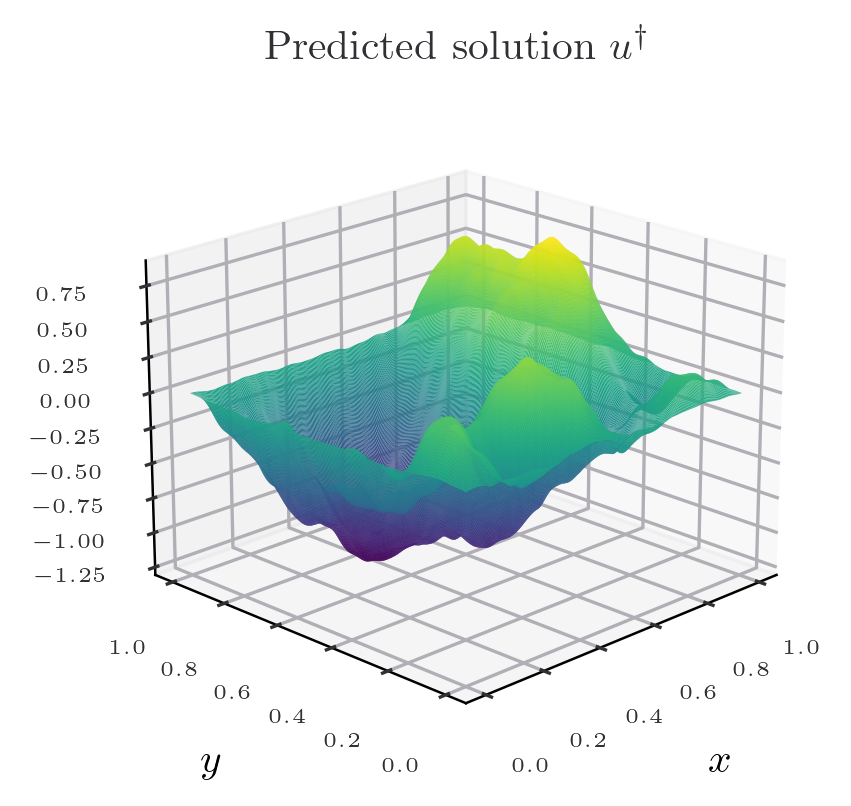

In [24]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

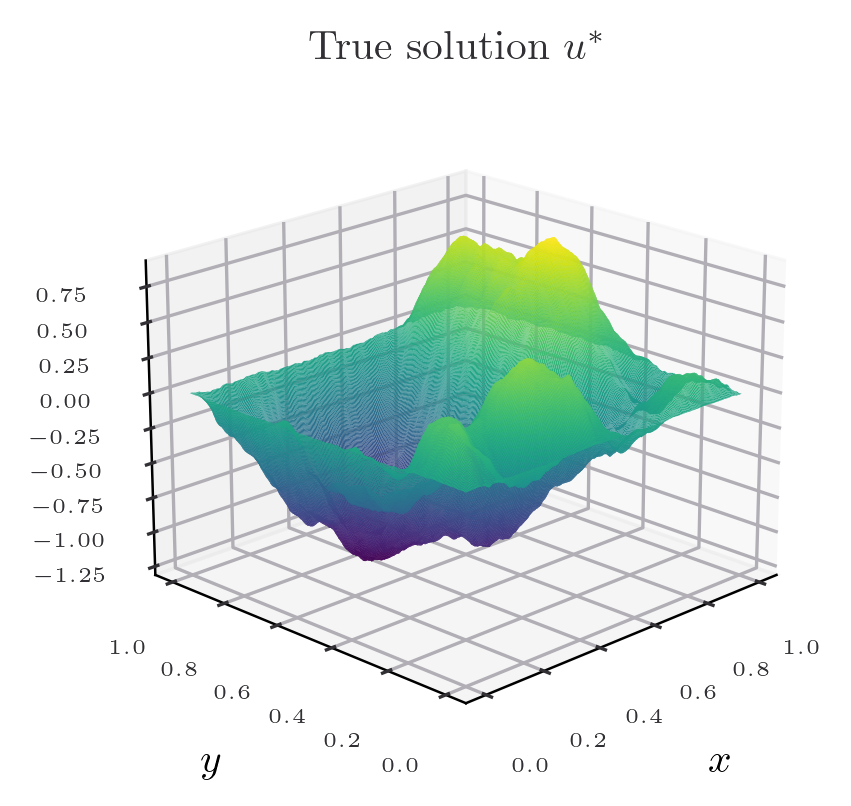

In [25]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

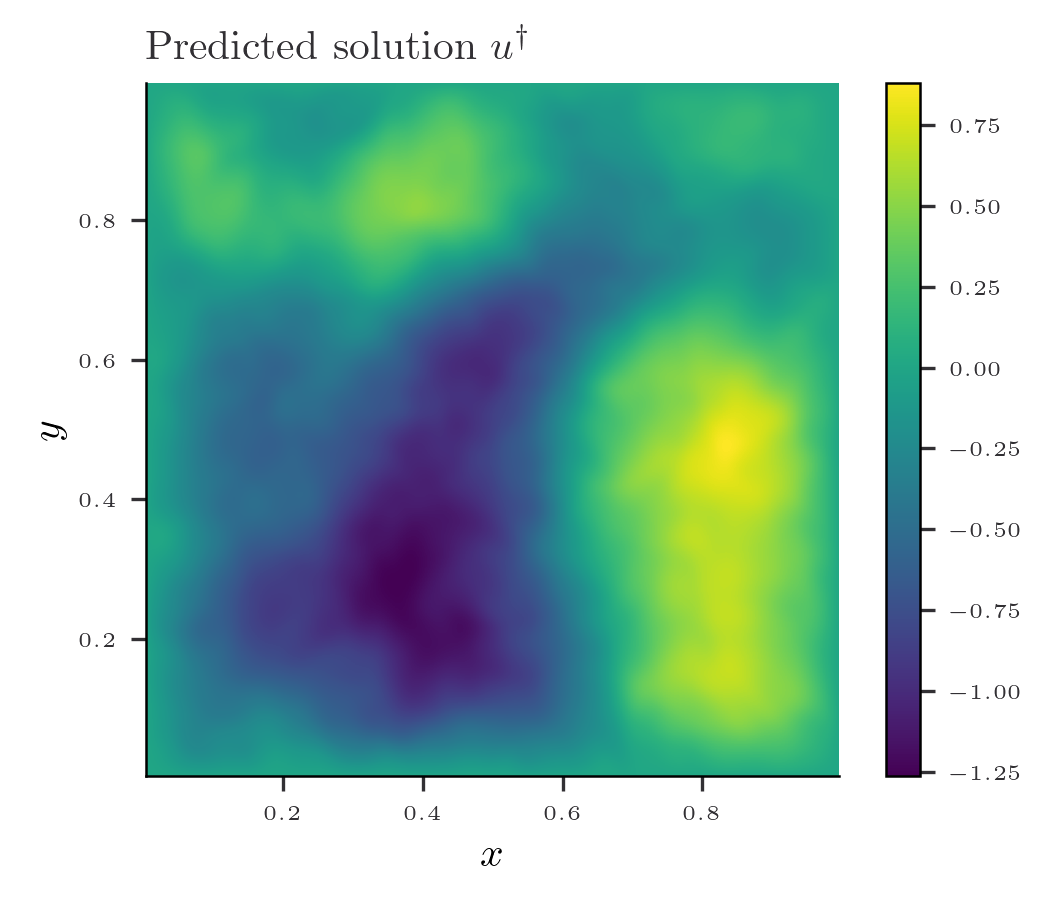

In [26]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

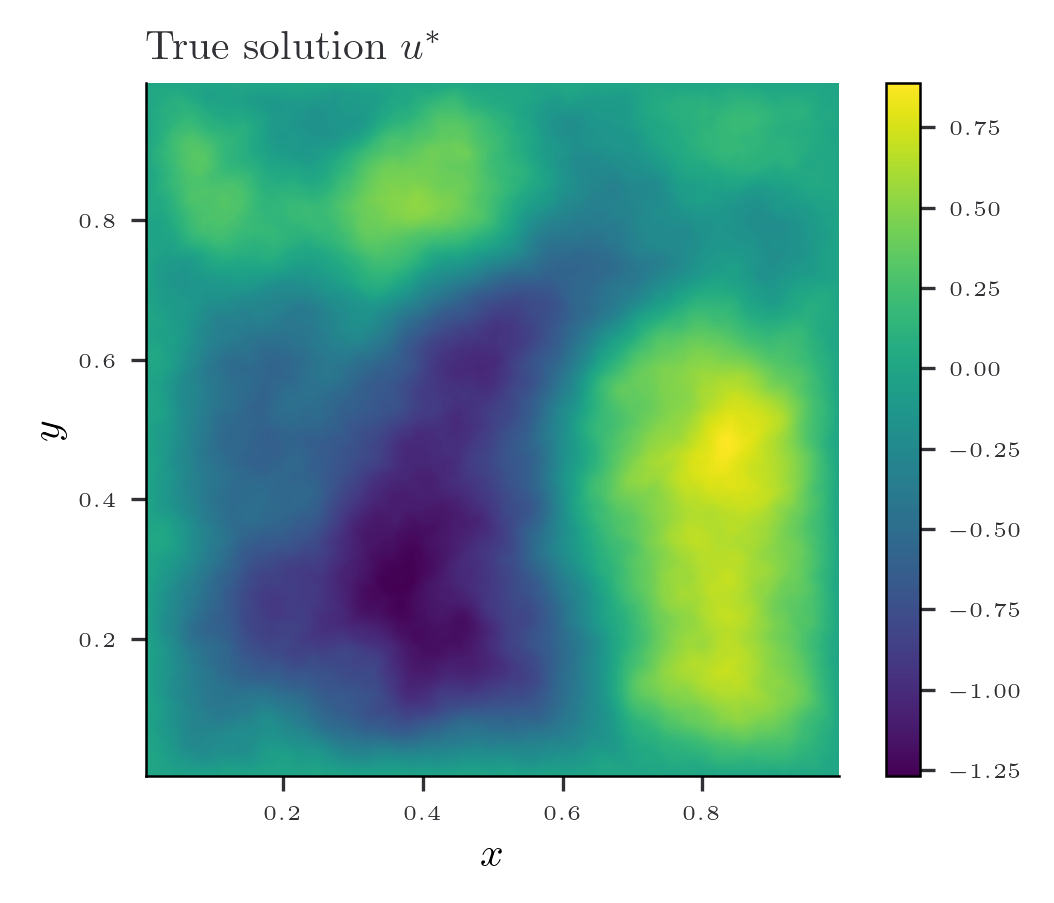

In [27]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

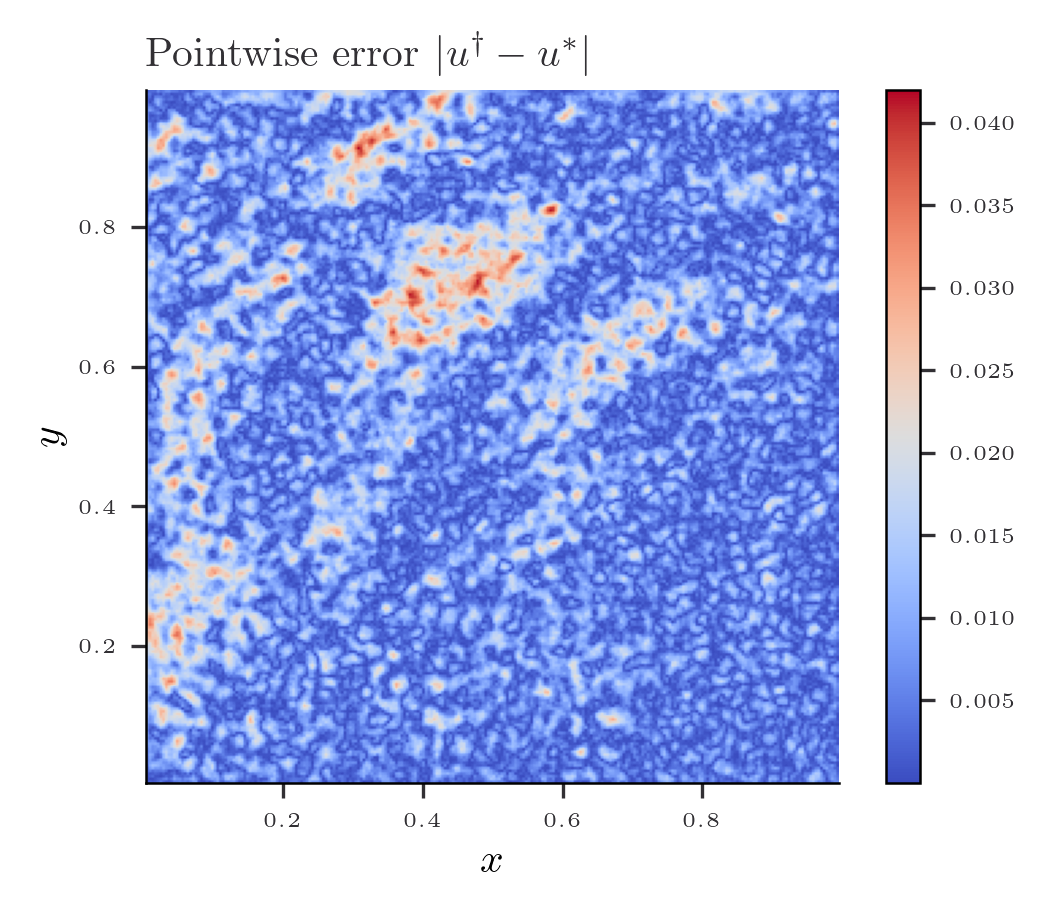

In [28]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

## Using a pointwise loss

In [30]:
f_observed = f_values[::int(n_coef/n_points), ::int(n_coef/n_points)] # The observations are the pointwise values

In [32]:
layer_sizes = [n_samples*2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

# Define the loss function (pointwise)
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred = -nu*laplacian_grid + vmap_b(x,y)*u_grid+ non_linearity # Here we do not take the DST
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

There are 8385 parameters in the neural network.


In [33]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [34]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 21499.3446802
Step 0, Training Loss: 21499.3446802, Learning Rate: 0.001000
Epoch 10000, Loss: 22.9584867
Step 10000, Training Loss: 22.9584867, Learning Rate: 0.000900
Epoch 20000, Loss: 7.3220509
Step 20000, Training Loss: 7.3220509, Learning Rate: 0.000810
Epoch 30000, Loss: 3.6704675
Step 30000, Training Loss: 3.6704675, Learning Rate: 0.000729
Epoch 40000, Loss: 2.9265122
Step 40000, Training Loss: 2.9265122, Learning Rate: 0.000656
Epoch 50000, Loss: 2.1885548
Step 50000, Training Loss: 2.1885548, Learning Rate: 0.000590
Epoch 60000, Loss: 1.1279735
Step 60000, Training Loss: 1.1279735, Learning Rate: 0.000531
Epoch 70000, Loss: 3.0908023
Step 70000, Training Loss: 3.0908023, Learning Rate: 0.000478
Epoch 80000, Loss: 0.8075736
Step 80000, Training Loss: 0.8075736, Learning Rate: 0.000430
Epoch 90000, Loss: 0.3692271
Step 90000, Training Loss: 0.3692271, Learning Rate: 0.000387


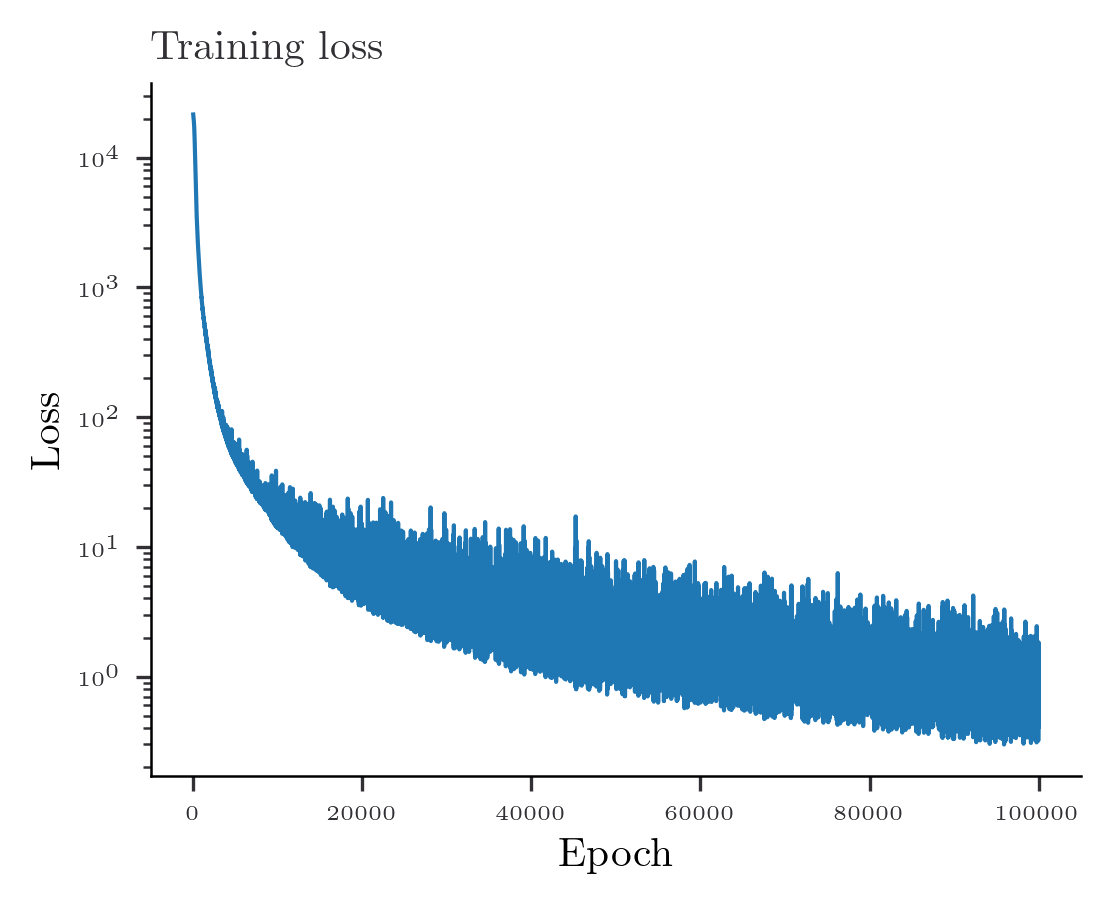

In [35]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [42]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)
e, e_rel = compute_2d_error(pred_grid, u_eval, x_eval, y_eval)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 1.74e+00. The relative L^2 error is 3.40e+00


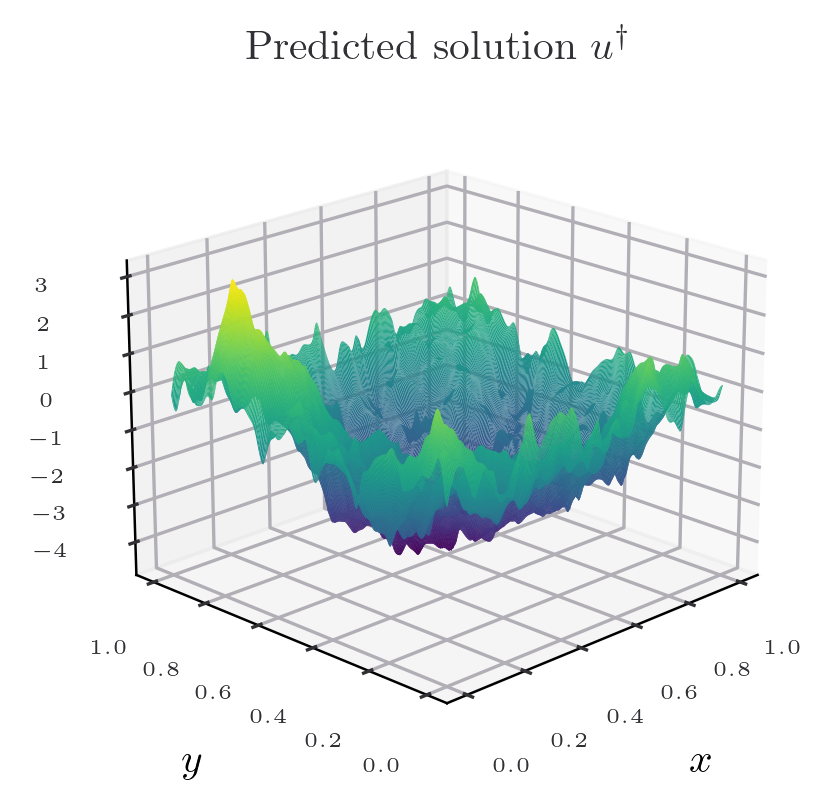

In [43]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

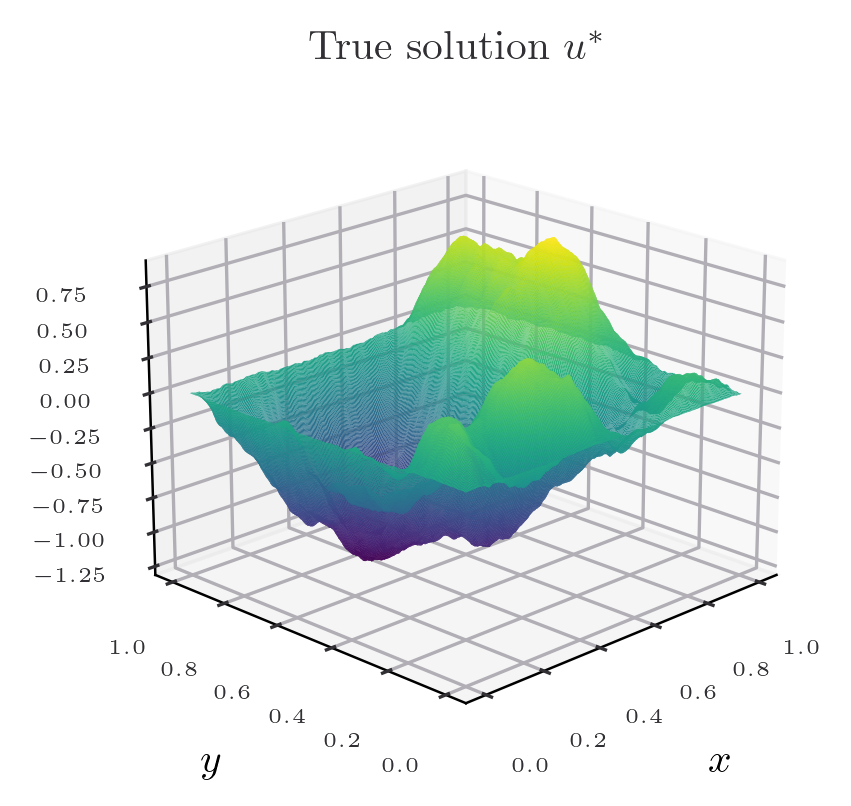

In [44]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

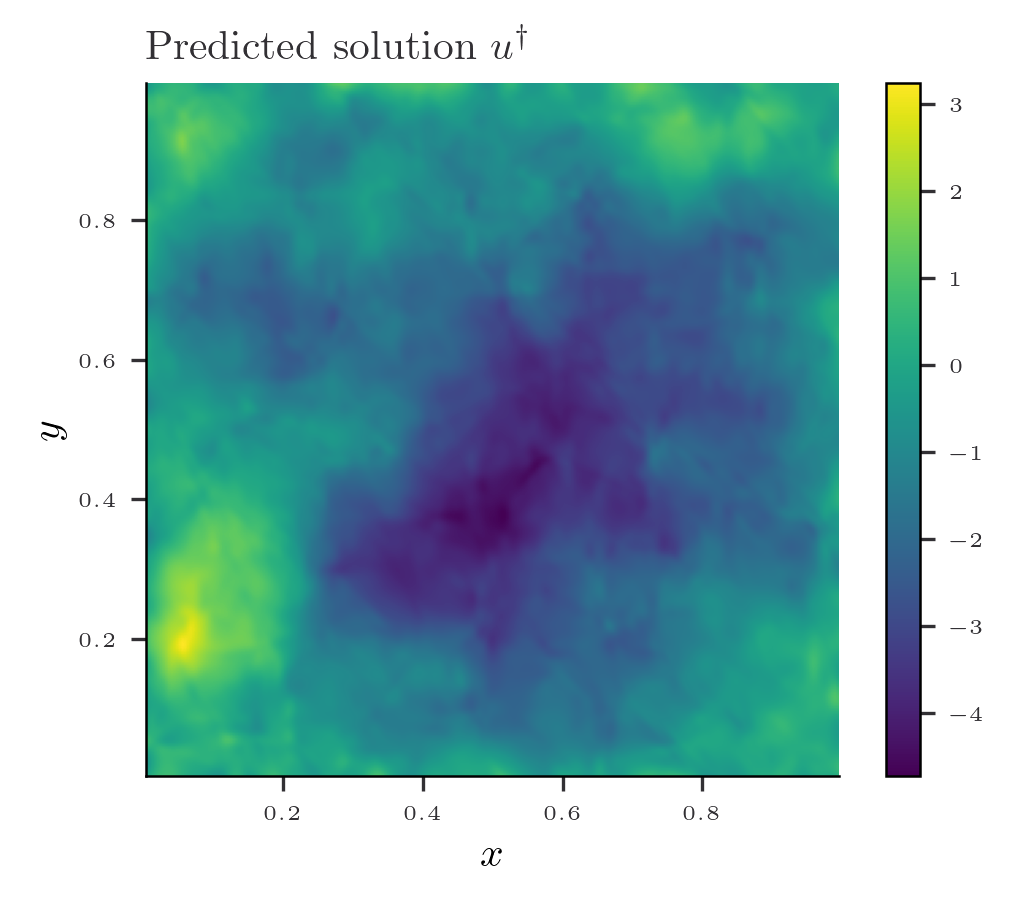

In [45]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

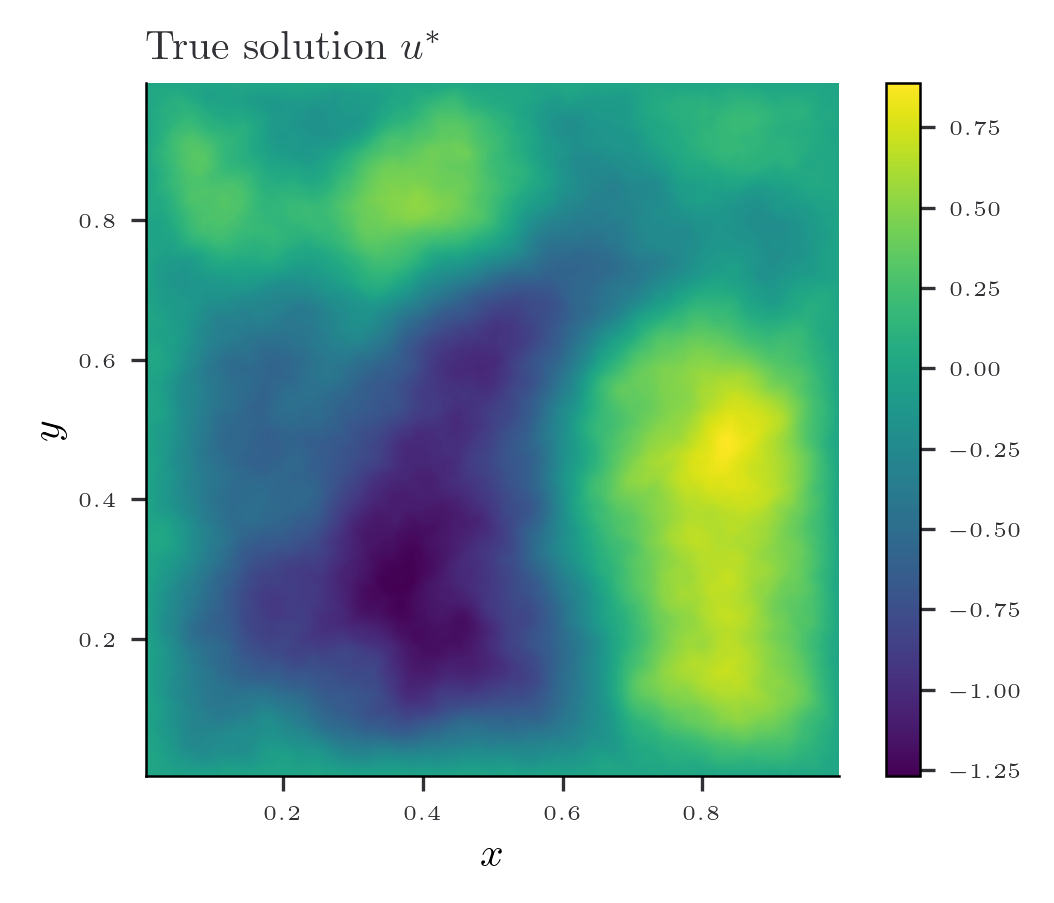

In [46]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

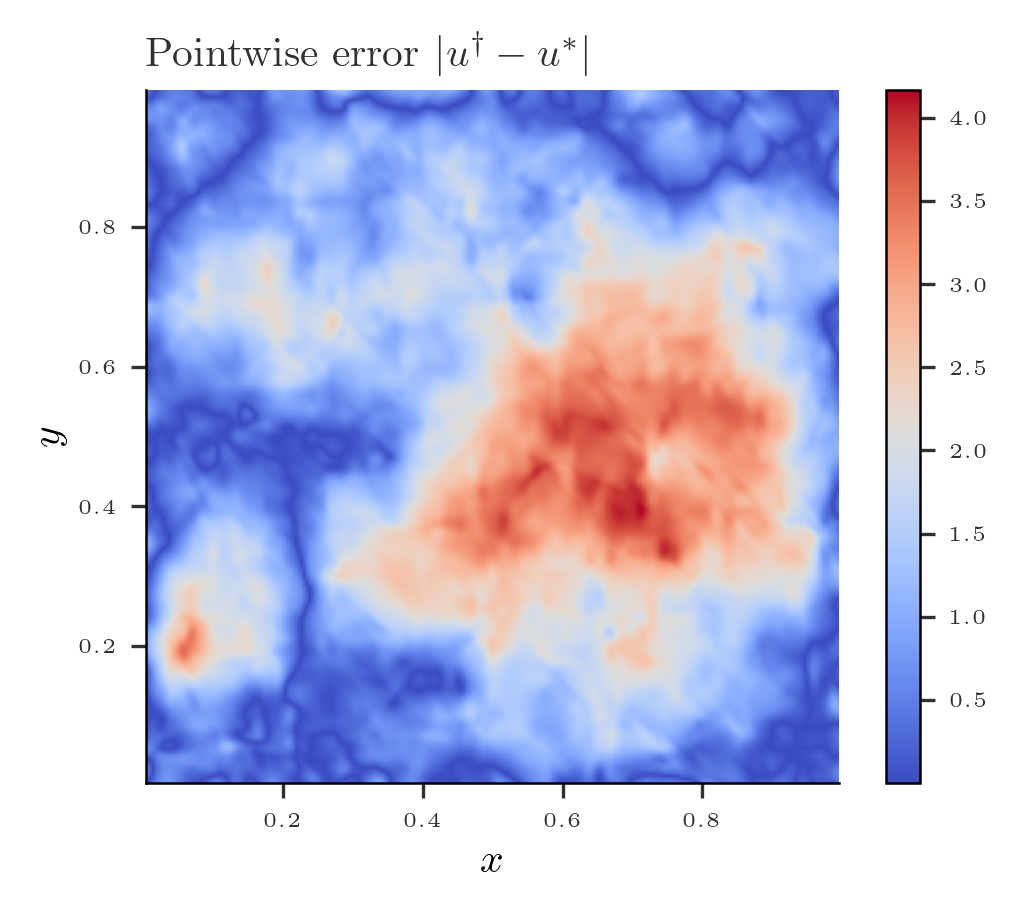

: 

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()